<h1>Naive Bayes Classifier</h1>

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, confusion_matrix
from sklearn.decomposition import PCA

Reading the data set

In [2]:
data = pd.read_csv('../data/tracks_with_binary_target.csv')
data.set_index('title', inplace=True)
data.head()

,artist,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity,is_dance_pop
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",Train,3.693075,78,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83,0
Love The Way You Lie,Eminem,44.814807,94,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82,0
TiK ToK,Kesha,6.410236,81,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80,1
Bad Romance,Lady Gaga,17.680180,89,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79,1
Just the Way You Are,Bruno Mars,31.020064,93,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78,0


Because the Naive Bayes cannot work with categorical features expressed as string values, we need to use LabelEncoder to encode them to integer values. I am not using OneHotEncoding since the number of possible categories for artist is large. <br>
Additionally, scaling is not critical for the algorithm so it is not performed.

In [4]:
data['artist'] = data[['artist']].apply(LabelEncoder().fit_transform)
data.head()

,artist,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity,is_dance_pop
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",200,3.693075,78,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83,0
Love The Way You Lie,58,44.814807,94,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82,0
TiK ToK,103,6.410236,81,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80,1
Bad Romance,108,17.680180,89,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79,1
Just the Way You Are,26,31.020064,93,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78,0


Split the data into train and test set with 80% - 20% proportions

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(
    data.drop(['is_dance_pop'], axis=1),
    data['is_dance_pop'],
    test_size = 0.2,
    random_state = 0
)

Let's try with the base classifier and without inspecting variable correlations, using all of the predictors.

In [6]:
nb_classifier = GaussianNB()

In [7]:
nb_classifier.fit(X_train, Y_train)

GaussianNB()

In [9]:
y_predicted_base = nb_classifier.predict(X_test)

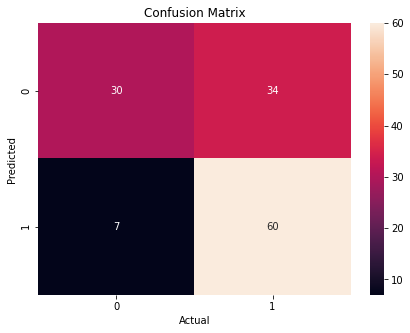

In [10]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(Y_test, y_predicted_base), annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

From the confusion matrix, we can see that the classifier has an almost even probability of predictiong 0 and 1 class. But it wrongly predicts many actual dance pop track as non dance pop. Maybe adding a prior can fix this, or removing correlated features.

A less biased approach would be to try cross-validation. Let's try this next.


Cross validation

In [11]:
def cross_validation_nb(X, Y, clf):
  predicted = []
  actual = []
  folds = KFold(n_splits=10, shuffle=True, random_state=0)

  for train_ind, test_ind in folds.split(X):
    X_train = X.iloc[train_ind]
    Y_train = Y.iloc[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y.iloc[test_ind]
    clf.fit(X_train, Y_train)
    predicted_vals = clf.predict(X_test)
    predicted.extend(predicted_vals)
    actual.extend(Y_test.to_list())
  
  score = cross_val_score(clf, X, Y)

  return predicted, actual, score

In [12]:
predicted, actual, score_cv = cross_validation_nb(data.drop(['is_dance_pop'], axis=1), data['is_dance_pop'], nb_classifier)

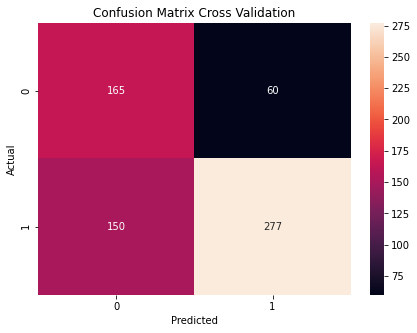

In [13]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(predicted, actual), annot=True, fmt='.5g')
plt.title('Confusion Matrix Cross Validation')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The confusion matrix on the full data set, from the cross validation predictions shows a different situation. This time the model predicts 0 for more samples that are from the 1 class (aka dance pop). 

In [14]:
score_cv

array([0.58015267, 0.67938931, 0.69230769, 0.70769231, 0.66153846])

On the first fold of 5 total, the model performs a bit worse than on the other folds.

Scores from the 5 folds of cross-validation

In [15]:
score_cv.mean()

0.6642160892542572

The mean cross validation score is approximately 0.66. Let's check the other metrics.

<h3>Evaluating the base model for heldout and cross-validation method</h3>

In [17]:
f1_heldout = f1_score(Y_test, y_predicted_default)
accuracy_heldout = accuracy_score(Y_test, y_predicted_default)
precision_heldout = precision_score(Y_test, y_predicted_default)
recall_heldout = recall_score(Y_test, y_predicted_default)
######
f1_cv = f1_score(actual, predicted)
accuracy_cv = accuracy_score(actual, predicted)
precision_cv = precision_score(actual, predicted)
recall_cv = recall_score(actual, predicted)

In [18]:
print('Heldout method')
print(f'F1_score heldout: {f1_heldout}')
print(f'Accuracy heldout: {accuracy_heldout}')
print(f'Precision heldout: {precision_heldout}')
print(f'Recall heldout: {recall_heldout}')
print('------------------------------------')
print('Cross validation')
print(f'F1_score cv: {f1_cv}')
print(f'Accuracy cv: {accuracy_cv}')
print(f'Precision cv: {precision_cv}')
print(f'Recall cv: {recall_cv}')

Heldout method
F1_score heldout: 0.7453416149068323
Accuracy heldout: 0.6870229007633588
Precision heldout: 0.6382978723404256
Recall heldout: 0.8955223880597015
------------------------------------
Cross validation
F1_score cv: 0.725130890052356
Accuracy cv: 0.6779141104294478
Precision cv: 0.6487119437939111
Recall cv: 0.8219584569732937


In [19]:
def draw_figure_metrics(f1_h, acc_h, rec_h, prec_h, f1_cv, acc_cv, rec_cv, prec_cv, graph_name='base model'):
  plt.figure(figsize=(15,10))
  plt.subplot(1,2,1)
  plt.bar(1, acc_h)
  plt.bar(2, rec_h)
  plt.bar(3, prec_h)
  plt.bar(4, f1_h)
  plt.xticks([1,2,3,4], ['accuracy', 'recall', 'precision', 'f1 score'])
  plt.title('Heldout method metrics - ' + str(graph_name))
  plt.subplot(1,2,2)
  plt.bar(1, acc_cv)
  plt.bar(2, rec_cv)
  plt.bar(3, prec_cv)
  plt.bar(4, f1_cv)
  plt.xticks([1,2,3,4], ['accuracy', 'recall', 'precision', 'f1 score'])
  plt.title('Cross validation method metrics - ' + str(graph_name))
  plt.show()

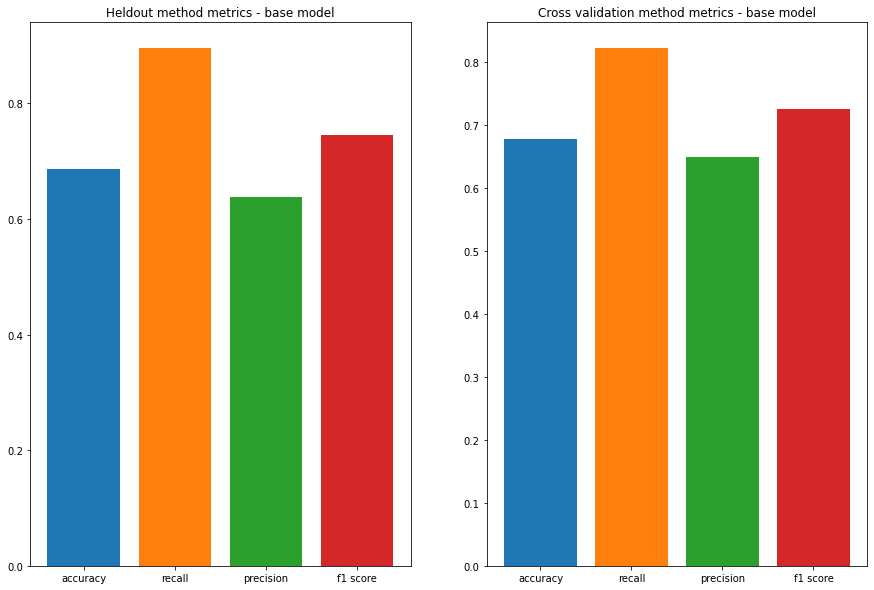

In [20]:
draw_figure_metrics(f1_heldout, accuracy_heldout, recall_heldout, precision_heldout,
                    f1_cv, accuracy_cv, recall_cv, precision_cv)

We can see that the metrics are proportional for both methods. The recall has the best score compared to the other metrics.

Now, let's inspect the correlation, or between feature dependence.

<h3>Inspecting Correlated Variables</h3>

Only calculating pearson's corellation for the continuous variables.

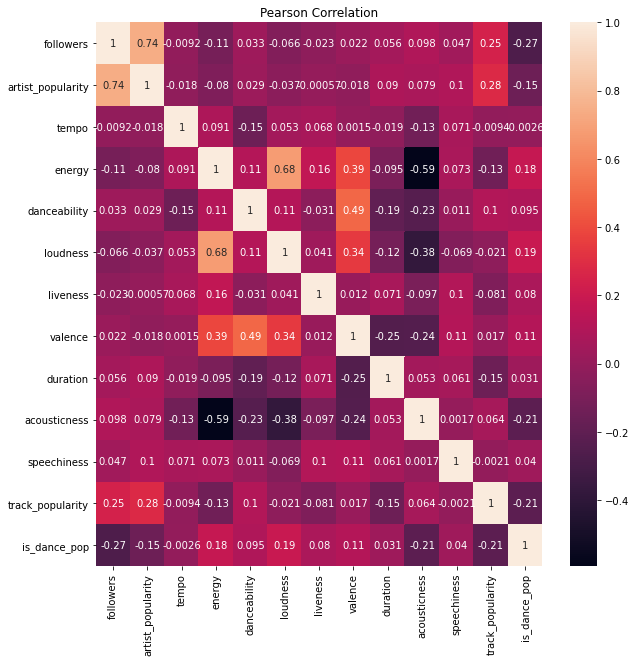

In [21]:
plt.figure(figsize=(10,10))
sns.heatmap(data[data.columns.drop(['artist', 'year'])].corr(), annot=True)
plt.title('Pearson Correlation')
plt.show()

It is evident that artist popularity and followers have a high positive correlation of 0.74. We need to keep one of the attributes. Since artist_popularity is a bit more correlated with the target, I decided to drop followers. Additionally, energy and loudness have a high positive correlation of 0.68 and energy and acousticness have a negative correlation of -0.59. For this reason, I decide to drop energy, since it provides a lot of the same information with these other two variables. The other variables remain the same.

In [22]:
data_not_correlated = data.drop(['followers', 'energy'], axis=1)

The new correlation matrix:

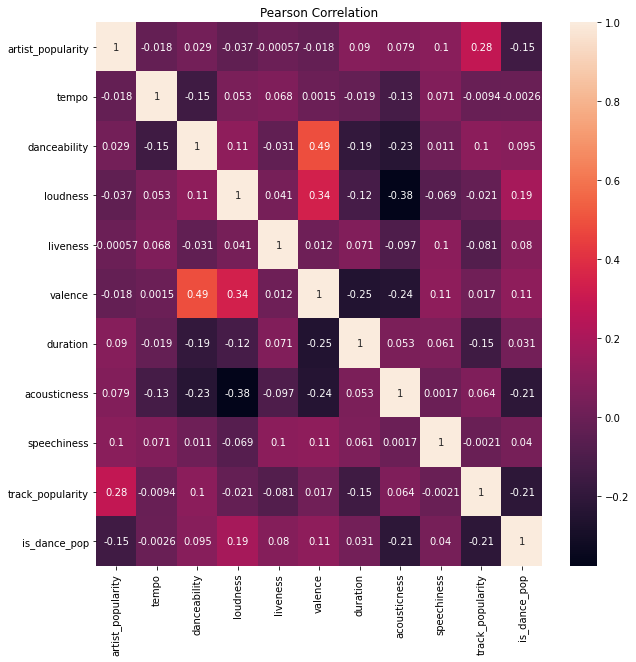

In [23]:
plt.figure(figsize=(10,10))
sns.heatmap(data_not_correlated[data_not_correlated.columns.drop(['artist', 'year'])].corr(), annot=True)
plt.title('Pearson Correlation')
plt.show()

Now the highest correlation is 0.49 between danceability and valence, but i decide to keep them both.

Now let's try the base model on these features

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(
    data_not_correlated.drop(['is_dance_pop'], axis=1),
    data_not_correlated['is_dance_pop'],
    test_size=0.2,
    random_state=0
)

In [25]:
nb_classifier.fit(X_train, Y_train)

GaussianNB()

In [26]:
y_predicted_removed_corr = nb_classifier.predict(X_test)

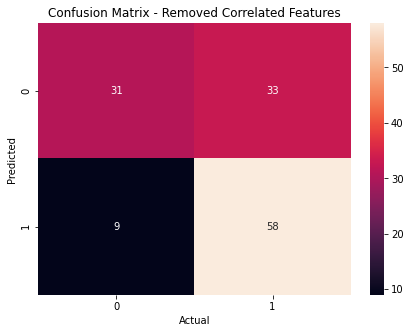

In [27]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(Y_test, y_predicted_removed_corr), annot=True)
plt.title('Confusion Matrix - Removed Correlated Features')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

The false negatives are lowered by 1 but the false positives are now greater by 2 than the case with all predictors.

Let's see for the full data set with cross_validation

In [28]:
predicted, actual, scores_cv = cross_validation_nb(data_not_correlated.drop(['is_dance_pop'],axis=1), data_not_correlated['is_dance_pop'], nb_classifier)

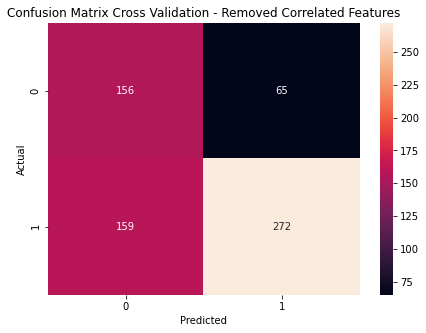

In [29]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(predicted, actual), annot=True, fmt='.5g')
plt.title('Confusion Matrix Cross Validation - Removed Correlated Features')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The cross validation score is almost the same as before but a bit worse towards the false negatives.


In [30]:
scores_cv

array([0.53435115, 0.63358779, 0.67692308, 0.7       , 0.62307692])

In [31]:
scores_cv.mean()

0.633587786259542

In [32]:
f1_heldout = f1_score(Y_test, y_predicted_removed_corr)
accuracy_heldout = accuracy_score(Y_test, y_predicted_removed_corr)
precision_heldout = precision_score(Y_test, y_predicted_removed_corr)
recall_heldout = recall_score(Y_test, y_predicted_removed_corr)
######
f1_cv = f1_score(actual, predicted)
accuracy_cv = accuracy_score(actual, predicted)
precision_cv = precision_score(actual, predicted)
recall_cv = recall_score(actual, predicted)

In [33]:
print(f'F1_score heldout: {f1_heldout}')
print(f'Accuracy heldout: {accuracy_heldout}')
print(f'Precision heldout: {precision_heldout}')
print(f'Recall heldout: {recall_heldout}')
print('------------------------------------')
print(f'F1_score cv: {f1_cv}')
print(f'Accuracy cv: {accuracy_cv}')
print(f'Precision cv: {precision_cv}')
print(f'Recall cv: {recall_cv}')

F1_score heldout: 0.7341772151898733
Accuracy heldout: 0.6793893129770993
Precision heldout: 0.6373626373626373
Recall heldout: 0.8656716417910447
------------------------------------
F1_score cv: 0.7083333333333333
Accuracy cv: 0.656441717791411
Precision cv: 0.6310904872389791
Recall cv: 0.8071216617210683


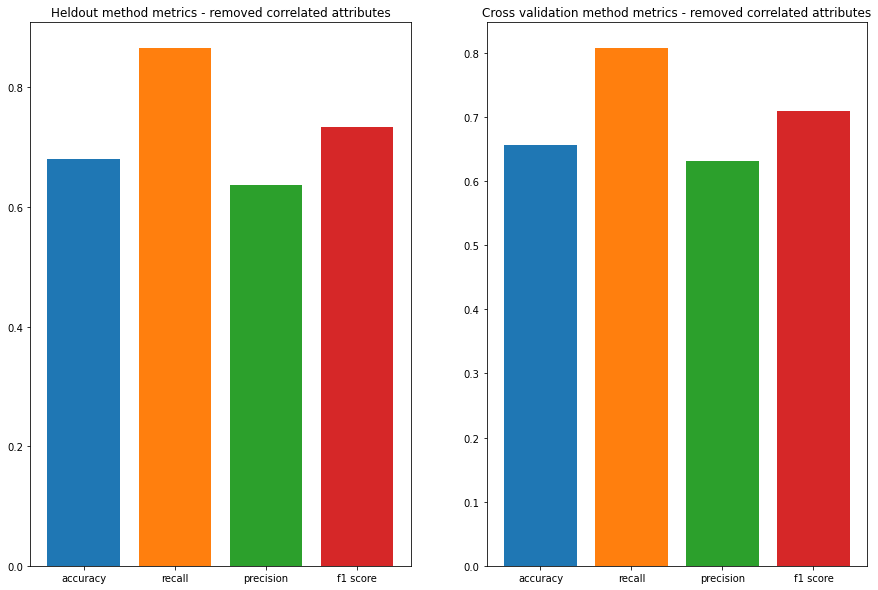

In [34]:
draw_figure_metrics(f1_heldout, accuracy_heldout, recall_heldout, precision_heldout,
                    f1_cv, accuracy_cv, recall_cv, precision_cv, 'removed correlated attributes')

<h3>Comparison of performance with/without correlated attributes with 0.5 prior<h3>

<pre>Since the class distribution in the data set is [   0   1   ]
                                                [ 0.48 0.52 ]
We may assume a fair prior distribution.<pre>                                               

In [35]:
nb_prior = GaussianNB(priors=[0.5, 0.5], var_smoothing=1e-5)

In [36]:
predicted_full, actual_full, scores_cv_full = cross_validation_nb(data.drop(['is_dance_pop'],axis=1), data['is_dance_pop'], nb_prior)

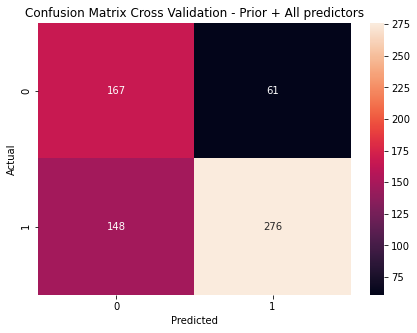

In [37]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(predicted_full, actual_full), annot=True, fmt='.5g')
plt.title('Confusion Matrix Cross Validation - Prior + All predictors')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Not much improvement from before by adding a prior.

In [39]:
scores_cv_full.mean()

0.6657428068115091

In [40]:
predicted_rem, actual_rem, scores_cv_rem = cross_validation_nb(data_not_correlated.drop(['is_dance_pop'],axis=1), data_not_correlated['is_dance_pop'], nb_prior)

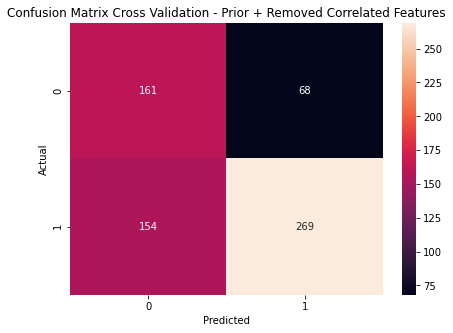

In [41]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(predicted_rem, actual_rem), annot=True, fmt='.5g')
plt.title('Confusion Matrix Cross Validation - Prior + Removed Correlated Features')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The performance of the data with removed correlated features and 0.5 prior for each class is a bit worse.

In [42]:
scores_cv_rem.mean()

0.6335760422783323

In [43]:
f1_full= f1_score(actual_full, predicted_full)
accuracy_full = accuracy_score(actual_full, predicted_full)
precision_full = precision_score(actual_full, predicted_full)
recall_full = recall_score(actual_full, predicted_full)
######
f1_rem = f1_score(actual_rem, predicted_rem)
accuracy_rem = accuracy_score(actual_rem, predicted_rem)
precision_rem = precision_score(actual_rem, predicted_rem)
recall_rem = recall_score(actual_rem, predicted_rem)

In [44]:
print(f'F1_score full data: {f1_full}')
print(f'Accuracy full data: {accuracy_full}')
print(f'Precision full data: {precision_full}')
print(f'Recall full data: {recall_full}')
print('------------------------------------')
print(f'F1_score removed correlated features: {f1_rem}')
print(f'Accuracy removed correlated features: {accuracy_rem}')
print(f'Precision removed correlated features: {precision_rem}')
print(f'Recall removed correlated features: {recall_rem}')

F1_score full data: 0.7253613666228648
Accuracy full data: 0.6794478527607362
Precision full data: 0.6509433962264151
Recall full data: 0.8189910979228486
------------------------------------
F1_score removed correlated features: 0.7078947368421052
Accuracy removed correlated features: 0.6595092024539877
Precision removed correlated features: 0.6359338061465721
Recall removed correlated features: 0.798219584569733


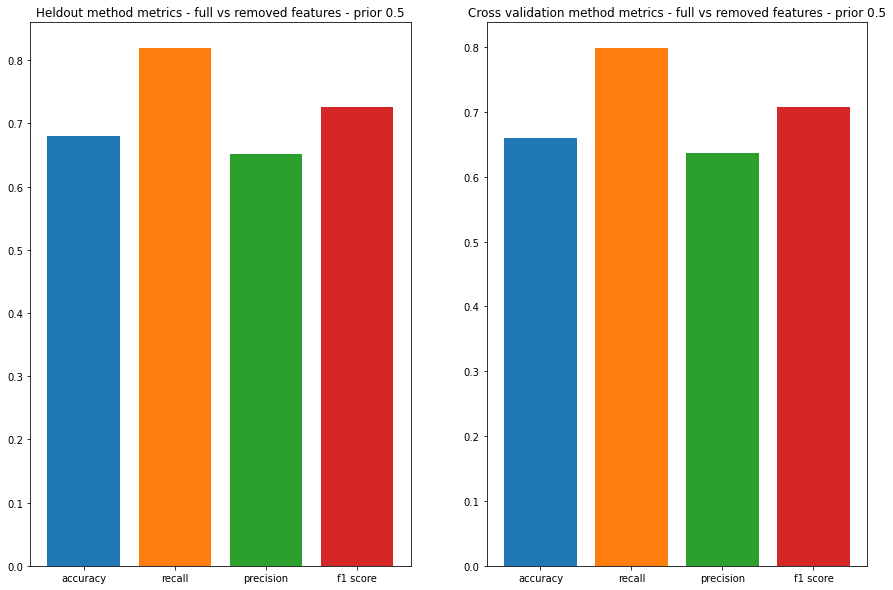

In [45]:
draw_figure_metrics(f1_full, accuracy_full, recall_full, precision_full,
                    f1_rem, accuracy_rem, recall_rem, precision_rem, 'full vs removed features - prior 0.5')

Generally, the performance did not improve when a prior was added, nor when correlated features were removed. It did not improve with applying the two techniques together. The best F1 score achieved with cross validation for Bayesian Classifier was approximately 0.725 on the original data set and no prior. <br> <br>
We can further use Naive Bayes classifier as a benchmark. Knowing that the higest score we've got was 0.725 F1 score.

Finally let's try performing pca on the features to remove any collinearity, it may be a benefit for Naive Bayes since it does not capture variable interactions.

In [56]:
pca = PCA(n_components = (len(data.columns) - 3))
X_transformed = pd.DataFrame(pca.fit_transform(data[data.columns.drop(['is_dance_pop', 'artist', 'year'])]))

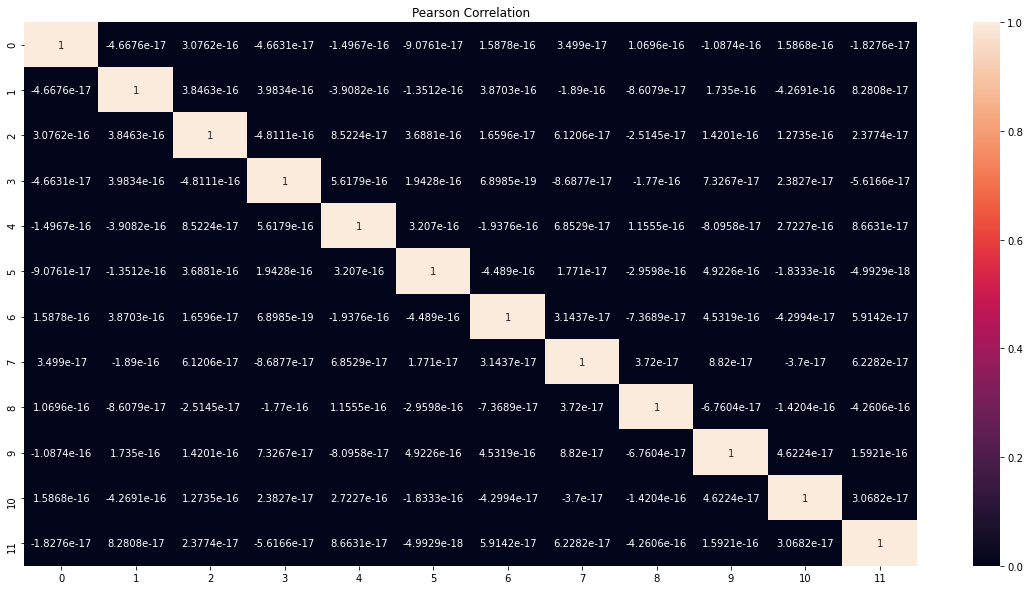

In [59]:
plt.figure(figsize=(20,10))
sns.heatmap(X_transformed.corr(), annot=True, fmt='.5g')
plt.title('Pearson Correlation')
plt.show()

We can see that the features are really not correlated now.

In [62]:
predicted_pca, actual_pca, scores_cv_pca = cross_validation_nb(X_transformed, data['is_dance_pop'], nb_classifier)

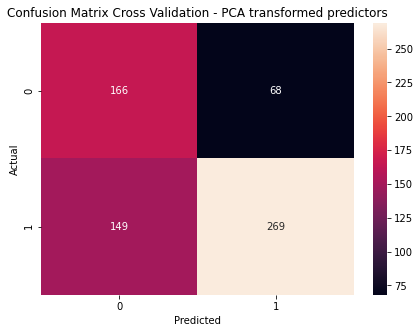

In [63]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(predicted_pca, actual_pca), annot=True, fmt='.5g')
plt.title('Confusion Matrix Cross Validation - PCA transformed predictors')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [64]:
scores_cv_pca.mean()

0.6504169113329419

In [66]:
f1_pca = f1_score(actual_pca, predicted_pca)
accuracy_pca = accuracy_score(actual_pca, predicted_pca)
precision_pca = precision_score(actual_pca, predicted_pca)
recall_pca = recall_score(actual_pca, predicted_pca)

In [67]:
print(f'F1_score pca transformed features: {f1_pca}')
print(f'Accuracy pca transformed features: {accuracy_pca}')
print(f'Precision pca transformed features: {precision_pca}')
print(f'Recall pca transformed features: {recall_pca}')

F1_score pca transformed features: 0.7125827814569536
Accuracy pca transformed features: 0.6671779141104295
Precision pca transformed features: 0.6435406698564593
Recall pca transformed features: 0.798219584569733


The PCA transformation did not improve the scores, they are actually pretty close to the socres of the removed correlated predictors.

<h3>Bayesian Belief Network<h3>

In [ ]:
!pip install pomegranate
!apt install libgraphviz-dev
!pip install pygraphviz

In [ ]:
from pomegranate import BayesianNetwork

In [ ]:
net = BayesianNetwork.from_samples(data, state_names=data.columns, algorithm='chow-liu')

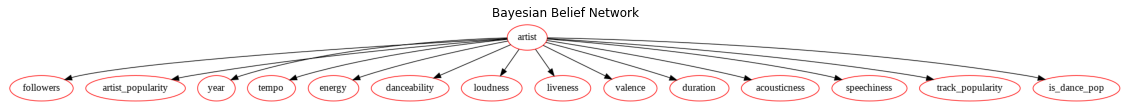

In [ ]:
plt.figure(figsize=(20,20))
net.plot()
plt.title('Bayesian Belief Network')
plt.show()

The netowrk suggest conditional dependence of the target variable is_dance_pop to the artist, which is reasonable since artists only make tracks from a few (or one) specific genres. All of the other attributes of the track depend on the artist. This is reasonable since artists make similar music occasionally.